In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
import load

df = load.load_df("../data/tissue_filtered_neuroplastoma.csv")
df_genes = df.iloc[:, 3:]
genes = df_genes.columns

df_unscaled = df.copy()
df_unscaled.iloc[:, 3:] = 2 ** df_unscaled.iloc[:, 3:] - 1

In [33]:
from scoring import Scoring, linkage_map
from plotting import Plotting

## GA

In [10]:
from ga import GA

# this means:
# 1. maximize on the log-scaled data
# 2. plot on the unscaled data
plotting = Plotting(df_unscaled, Scoring(df_unscaled))
ga = GA(genes, Scoring(df), plotting)

In [ ]:
plotting.boxplot(best_sols[0].iloc[5, :5].values)

In [18]:
for meth in ["single"]:
    for num_genes in [5, 10, 20]:
        for rep in range(3):
            fitness_func = lambda x, y: _fitness_func(x, y, meth)
            ga.run_instance(fitness_func, num_genes, meth)

AttributeError: 'GA' object has no attribute 'run_instance'

## Load results

In [34]:
import load

results = load.Results(Scoring(df))

In [38]:
%%time
#for n in [5, 10, 20]:
 #   sols = results.collect_and_save(n, linkage_map.keys())

for n in [5, 10, 20]:
    sols = results.collect_and_save(n, ["rf"])

['54_rf_5', '57_rf_5_trim25', '78_rf_5_trim_heavy', '81_rf_5', '84_rf_5']
['55_rf_10', '58_rf_10_trim25', '79_rf_10_trim_heavy', '82_rf_10', '85_rf_10']
['56_rf_20', '59_rf_20_trim25', '80_rf_20_trim_heavy', '83_rf_20', '86_rf_20']
Wall time: 3min 6s


In [39]:
dfs = load.load_solutions()
dfs[0]

,0,1,2,3,4,single,median,average,quartile,quantile,approach
0,ATP6AP2,CD99,KCNQ2,SMPD4,VEZT,5.063818,8.668583,8.697351,7.732128,6.492009,ga
1,CD276,CD99,CLN3,KCNQ2,MARCH6,4.861751,9.056395,9.049559,7.885054,6.105046,ga
2,CD99,CHRNA7,KCNQ2,SMPD4,VEZT,4.808283,9.260378,9.303375,8.026950,6.270213,ga
3,CD99,KCNQ2,LMBR1,SMPD4,VEZT,4.750235,8.459247,8.516660,7.582120,6.075779,ga
4,CD99,CLN3,KCNQ2,MARCH6,VEZT,4.672258,8.581561,8.598082,7.569527,6.207233,ga
...,...,...,...,...,...,...,...,...,...,...,...
3717,KCNQ2,L1CAM,NCAM1,SDC4,VEZT,-11.035582,4.986375,5.011664,3.237809,0.517239,rf
3718,ATP1A3,CADM1,CHRNA3,NCAM1,NTRK1,-11.080726,11.336976,11.209123,7.435278,2.552565,ga
3719,CADM1,CD276,L1CAM,LMBR1L,SDC4,-11.125173,4.368533,4.324450,2.477205,-0.083799,rf
3720,CADM1,CD276,L1CAM,SDC4,ST7,-11.436810,4.153738,4.044385,2.576506,-0.261141,rf


<AxesSubplot:title={'center':'5 selected antigens: ATP6AP2, CD99, KCNQ2, SMPD4, VEZT'}, xlabel='tissue', ylabel='log2(TPM sum)'>

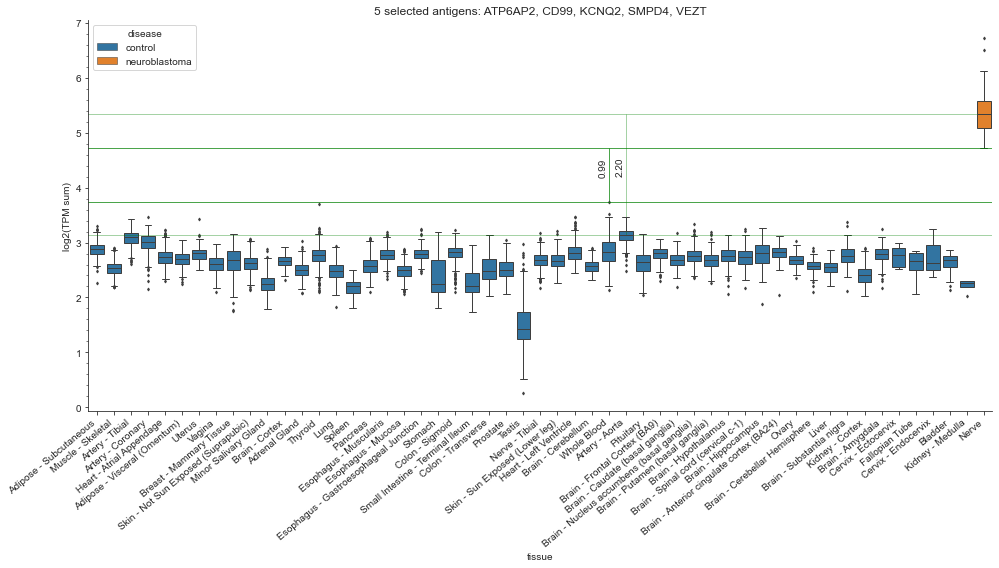

In [48]:
sel = dfs[0].iloc[0, :5].values
plotting.boxplot(sel)

In [68]:

# data.rename({"variable": "antigen", "value": "tpm_sum"})

<Figure size 4800x600 with 0 Axes>

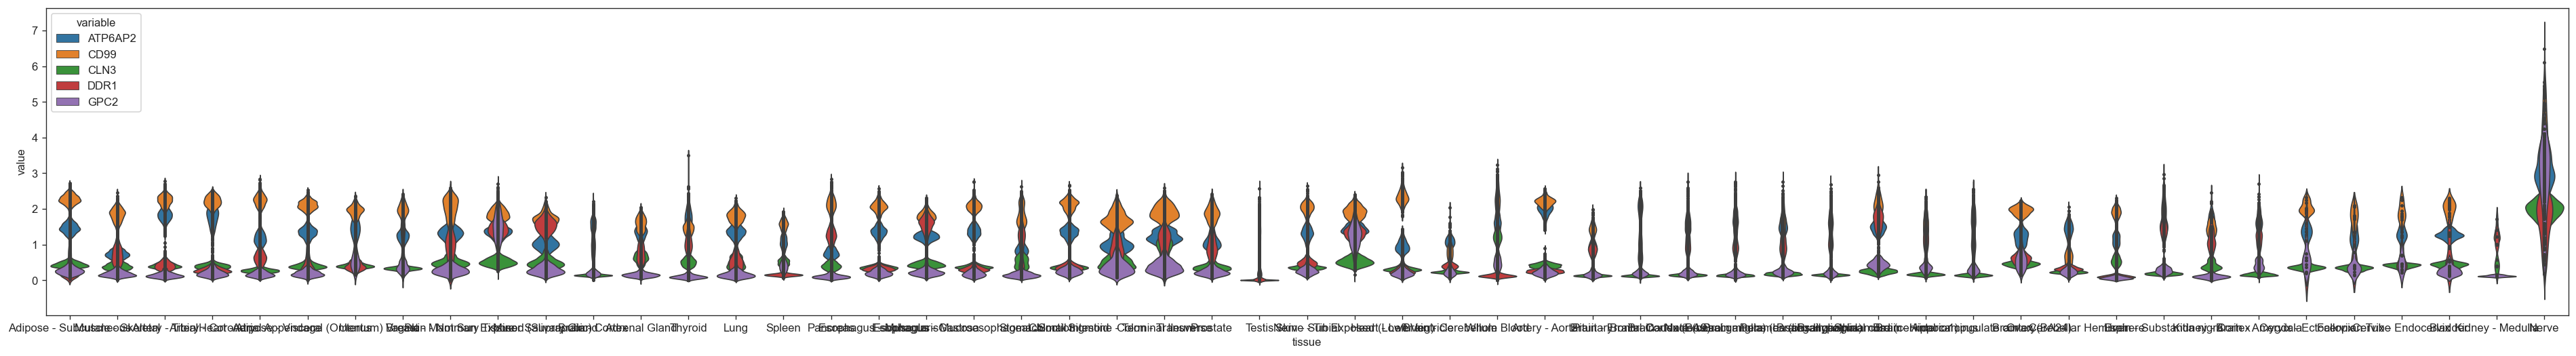

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

sel = dfs[1].iloc[0, :5].values
data = df[["tissue"] + list(sel)]
data = data.melt(id_vars="tissue")
# data

plt.figure(dpi=120, figsize=(40, 5))

plot = sns.violinplot(
    data=data,
    hue="variable",
    x="tissue",
    y="value",
    linewidth=1,
    flierprops=dict(markersize=1),
    dodge=False,
    inner="point",
)



Wall time: 17.2 s


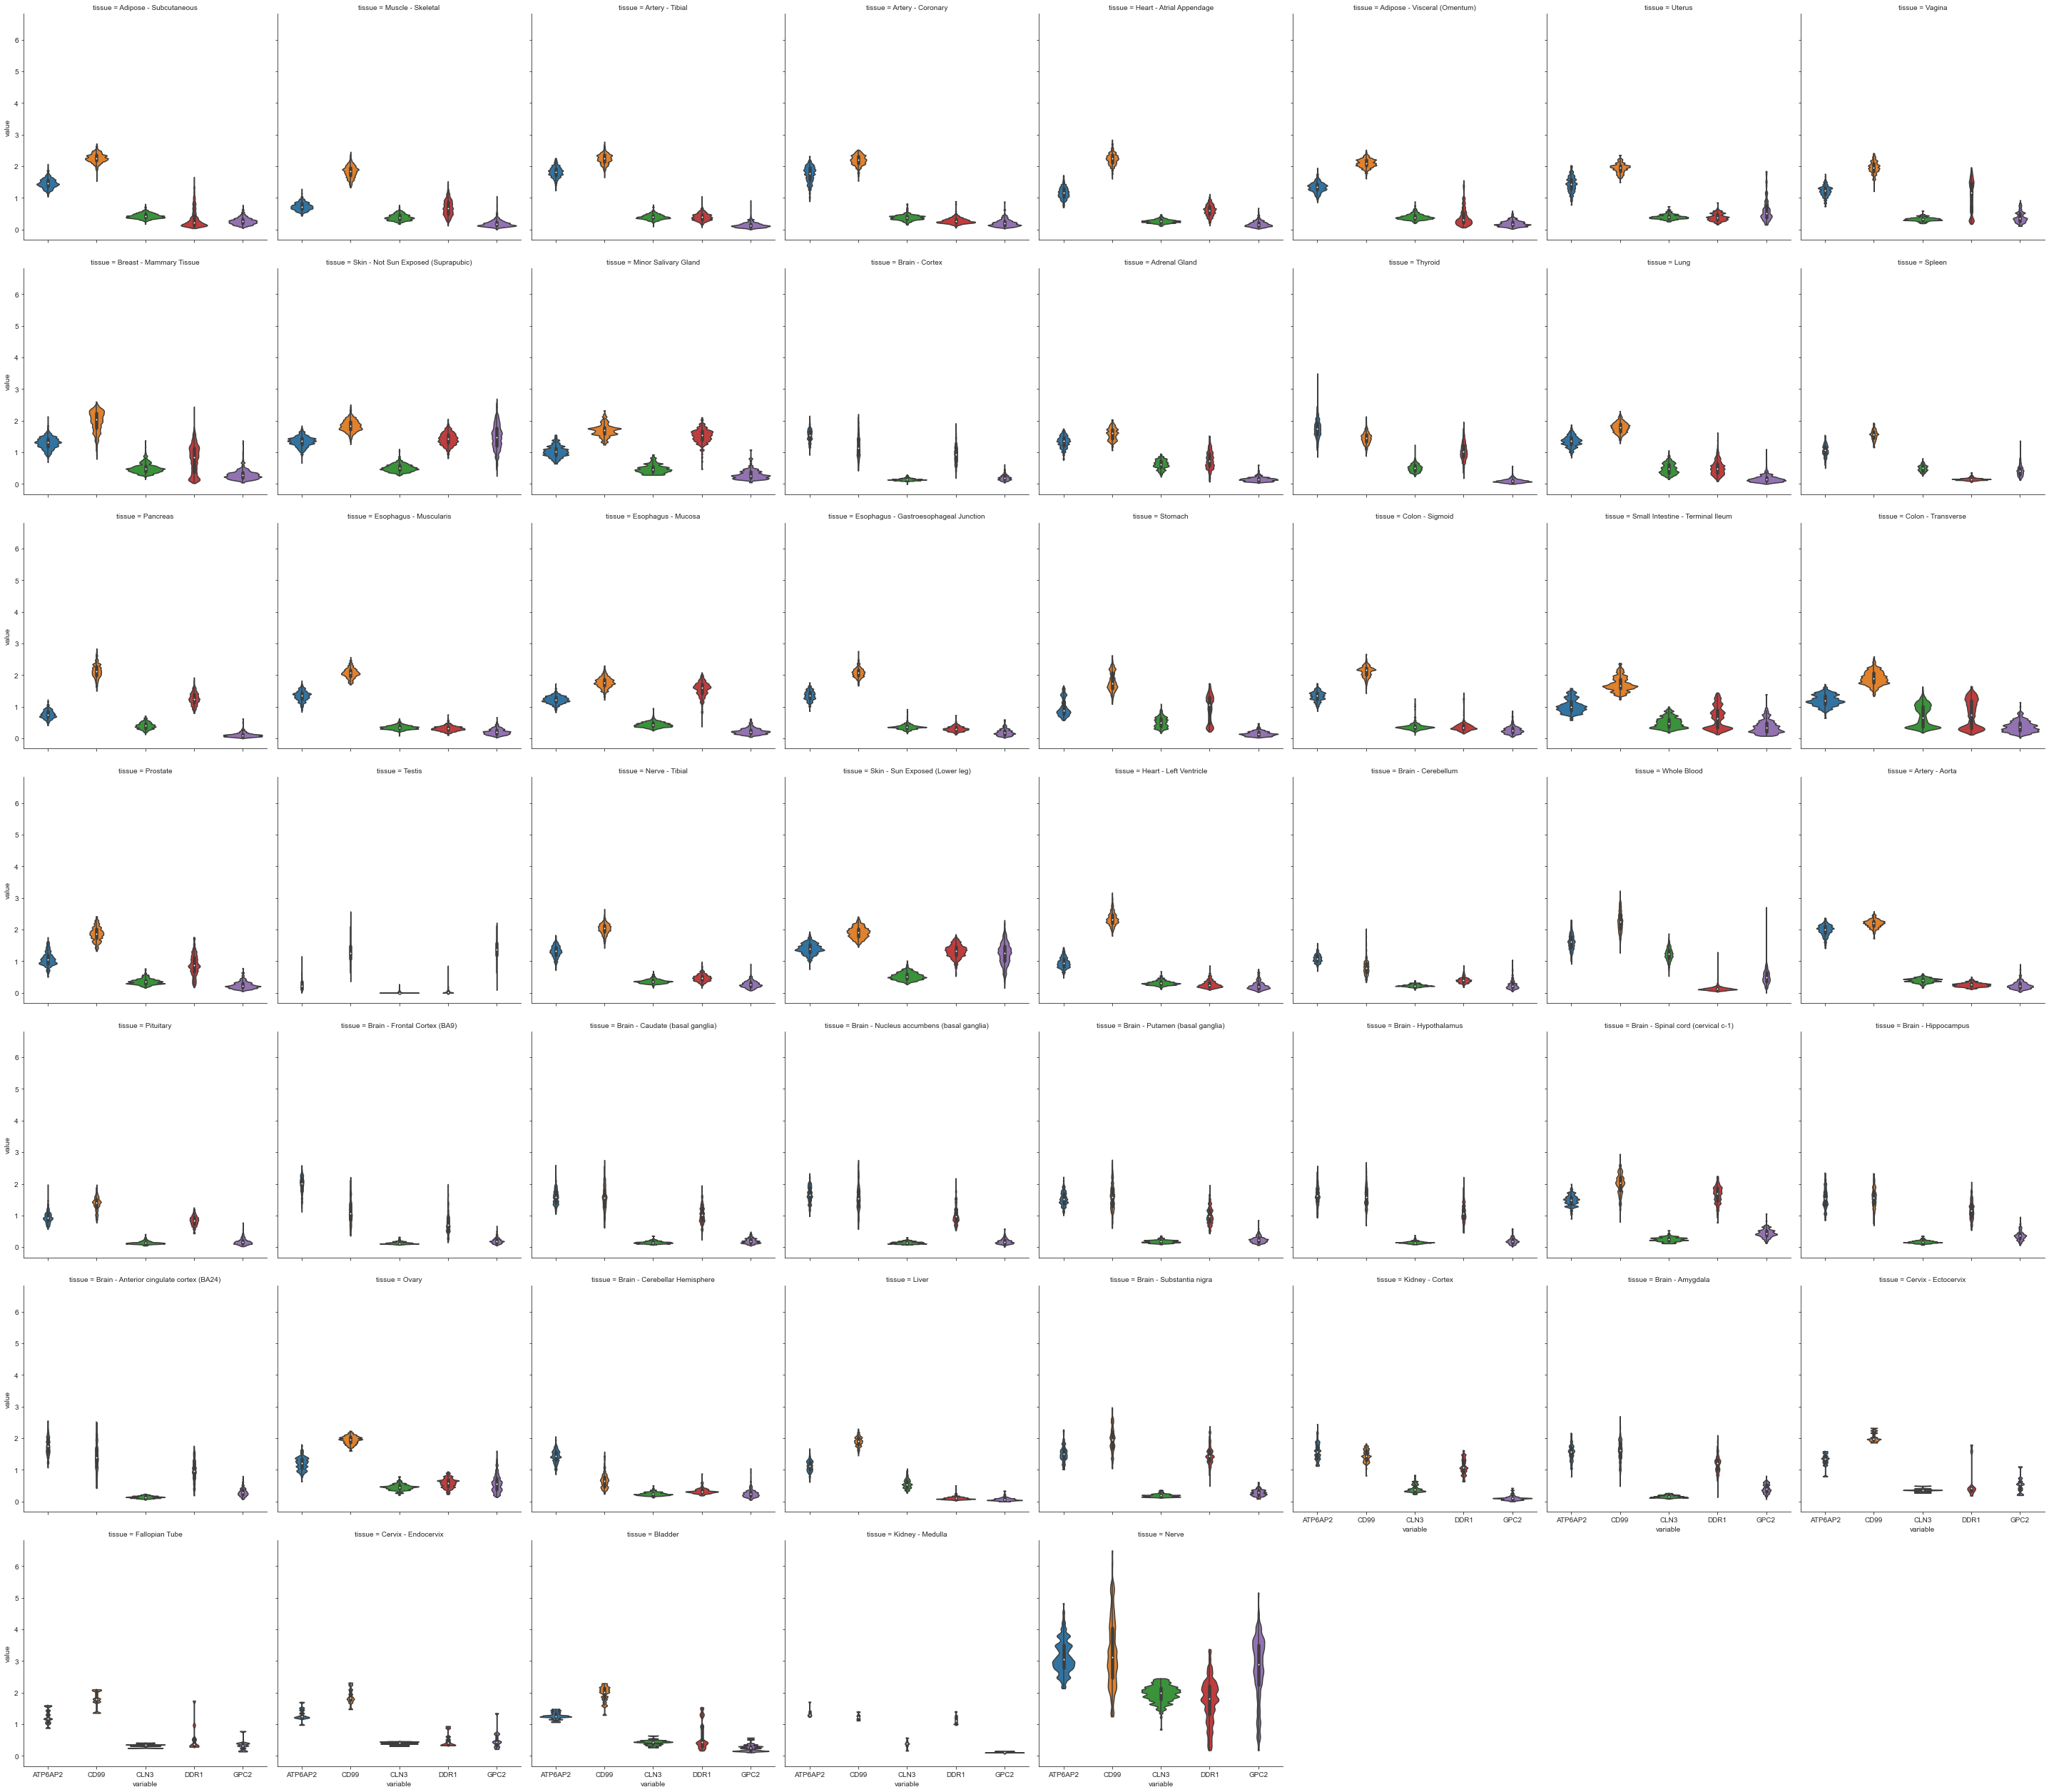

In [98]:
%%time
sns.catplot(
    y="value",
    x="variable",
    col="tissue",
    col_wrap=8,
    data=data,
    kind="violin",
    bw=.1,
    cut=0
)

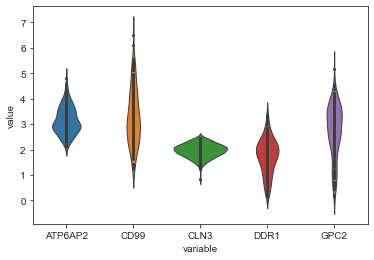

In [87]:
plot = sns.violinplot(
    data=data[data.tissue == "Nerve"],
    x="variable",
    y="value",
    linewidth=1,
    flierprops=dict(markersize=1),
    dodge=False,
    inner="point",
)

In [ ]:
best_sols = []
for d, n in zip(dfs, [5, 10, 20]):
    s = clean_and_eval([d.head(10)], n)
    best_sols.append(s)
    s.to_csv(f"top10_size{n}.csv")
    s.head(5)["single"]

In [ ]:
best_sols[0]

In [ ]:
vs = best_sols[0].iloc[0, :5].values
scoring.score(vs)
df["s"] = df[vs].sum(axis=1)
n = df[df.tissue == "Nerve"]["s"].min()
h = df[df.tissue != "Nerve"]["s"].max()
n
h
import math

n / h
math.log(n, 2) - math.log(h, 2)

In [ ]:
plotting.boxplot(best_sols[0].iloc[5, :5].values)

In [ ]:
s = df[list(best_sols[0].iloc[0, :5].values)].sum(axis=1)
s = pd.concat([df["tissue"], s], axis=1)
s[s.tissue == "Nerve"].min()
s[s.tissue != "Nerve"].max()

s[s.tissue == "Nerve"].min().values[1] / s[s.tissue != "Nerve"].max().values[1]